Using device: cuda

=== Fold 1/5 ===

Epoch 1/100
 [██████████████████████████████] 100.0%
Train Loss: 117.6388 | Train Acc: 0.5971
Validation Acc: 0.6337

Epoch 2/100
 [██████████████████████████████] 100.0%
Train Loss: 113.0813 | Train Acc: 0.6222
Validation Acc: 0.6250

Epoch 3/100
 [██████████████████████████████] 100.0%
Train Loss: 112.8905 | Train Acc: 0.6275
Validation Acc: 0.6319

Epoch 4/100
 [██████████████████████████████] 100.0%
Train Loss: 112.7896 | Train Acc: 0.6269
Validation Acc: 0.6302

Epoch 5/100
 [██████████████████████████████] 100.0%
Train Loss: 112.5844 | Train Acc: 0.6303
Validation Acc: 0.6297

Epoch 6/100
 [██████████████████████████████] 100.0%
Train Loss: 112.3728 | Train Acc: 0.6317
Validation Acc: 0.6387

Epoch 7/100
 [██████████████████████████████] 100.0%
Train Loss: 111.5820 | Train Acc: 0.6354
Validation Acc: 0.6600

Epoch 8/100
 [██████████████████████████████] 100.0%
Train Loss: 107.8579 | Train Acc: 0.6621
Validation Acc: 0.6859

Epoch 9/100
 [████

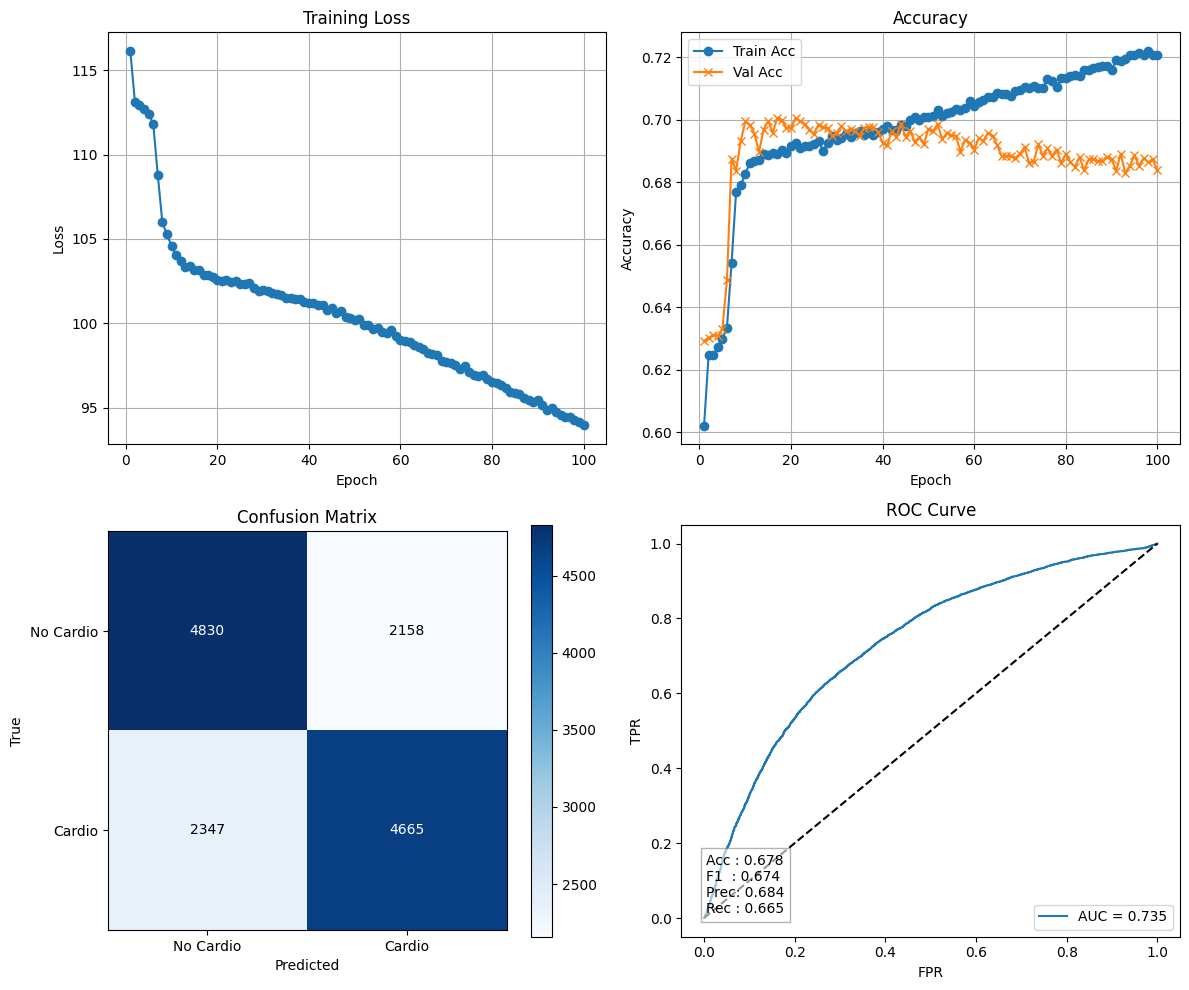

In [5]:
# K-CV法を用いた心疾患予測モデルの学習と評価,マスクなしでの学習，BMIなし
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, roc_curve,
    confusion_matrix
)
import numpy as np
import sys
import matplotlib.pyplot as plt

# --------------------------------------------
# 定数設定
# --------------------------------------------
EPOCHS = 100
THRESHOLD = 0.73
BATCH_SIZE = 256
K_FOLDS = 5

# --------------------------------------------
# 0. デバイス設定
# --------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------------------------
# 1. データ読み込み & 前処理
# --------------------------------------------

# データ読み込み
data = pd.read_csv("cardio_train.csv", sep=';')

# age_years のみ算出（BMI 削除）
data['age_years'] = (data['age'] / 365).astype(int)

# カテゴリ・連続量特徴量の定義
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
continuous_cols  = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']
target_col = 'cardio'

# ラベルエンコーディング
from sklearn.preprocessing import LabelEncoder, StandardScaler
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# 標準化
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])


# --------------------------------------------
# 2. Dataset クラス定義
# --------------------------------------------
class CardioDataset(Dataset):
    def __init__(self, df):
        self.categ  = df[categorical_cols].values.astype(np.int64)
        self.cont   = df[continuous_cols].values.astype(np.float32)
        self.labels = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.categ[idx], dtype=torch.int64),
            torch.tensor(self.cont[idx],  dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32),
        )

# --------------------------------------------
# 3. データ分割 (Train+Val / Test = 80/20)
# --------------------------------------------
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_loader = DataLoader(CardioDataset(test_data), batch_size=BATCH_SIZE, shuffle=False)

# --------------------------------------------
# 4. 学習・検証ループ用関数定義
# --------------------------------------------
def train_with_validation(model, train_loader, val_loader, epochs, threshold):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    loss_history, train_acc_history, val_acc_history = [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        print(f"\nEpoch {epoch}/{epochs}")
        for batch_idx, (x_cat, x_cont, y) in enumerate(train_loader, 1):
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x_cat, x_cont).squeeze(1)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            correct += (pred == y.int()).sum().item()
            total += y.size(0)
            # 進捗バー
            progress = batch_idx / len(train_loader) * 100
            bar_len = 30
            filled = int(bar_len * progress / 100)
            bar = '█' * filled + '-' * (bar_len - filled)
            sys.stdout.write(f"\r [{bar}] {progress:5.1f}%")
            sys.stdout.flush()

        loss_history.append(total_loss)
        train_acc_history.append(correct / total)
        print(f"\nTrain Loss: {total_loss:.4f} | Train Acc: {train_acc_history[-1]:.4f}")

        # 検証
        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for x_cat_v, x_cont_v, y_v in val_loader:
                x_cat_v, x_cont_v, y_v = x_cat_v.to(device), x_cont_v.to(device), y_v.to(device)
                out_v = model(x_cat_v, x_cont_v).squeeze(1)
                prob_v = torch.sigmoid(out_v)
                pred_v = (prob_v > 0.5).int()
                val_preds.extend(pred_v.cpu().tolist())
                val_trues.extend(y_v.cpu().int().tolist())

        val_acc = accuracy_score(val_trues, val_preds)
        val_acc_history.append(val_acc)
        print(f"Validation Acc: {val_acc:.4f}")

        if val_acc >= threshold:
            print(f"Threshold {threshold:.4f} reached at epoch {epoch}. Stopping training.")
            break

    return loss_history, train_acc_history, val_acc_history


# --------------------------------------------
# 5. テストデータ評価用関数定義
# --------------------------------------------
def evaluate_model(model, loader):
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            out = model(x_cat, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            preds.extend((prob > 0.5).int().cpu().tolist())
            trues.extend(y.int().cpu().tolist())
            probs.extend(prob.cpu().tolist())

    print("\nTest Metrics:")
    print(f"Accuracy : {accuracy_score(trues, preds):.4f}")
    print(f"F1 Score : {f1_score(trues, preds):.4f}")
    print(f"Precision: {precision_score(trues, preds):.4f}")
    print(f"Recall   : {recall_score(trues, preds):.4f}")
    print(f"AUC      : {roc_auc_score(trues, probs):.4f}")


# --------------------------------------------
# 6. まとめて4つのグラフを描画＆保存する関数定義
# --------------------------------------------
# --------------------------------------------
# 8. K-Fold Cross Validation
# --------------------------------------------
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_data), 1):
    print(f"\n=== Fold {fold}/{K_FOLDS} ===")
    train_df = train_val_data.iloc[train_idx].reset_index(drop=True)
    val_df   = train_val_data.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(CardioDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(CardioDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False)

    # モデル初期化
    cont_mean_std = torch.tensor([[0., 1.]] * len(continuous_cols)).to(device)
    model = TabTransformer(
        categories=tuple(data[col].nunique() for col in categorical_cols),
        num_continuous=len(continuous_cols),
        dim=32, dim_out=1, depth=4, heads=4,
        attn_dropout=0.1, ff_dropout=0.1,
        mlp_hidden_mults=(4, 2), mlp_act=nn.ReLU(),
        continuous_mean_std=cont_mean_std
    ).to(device)
    model.categories_offset = model.categories_offset.to(device)

    _, _, val_accs = train_with_validation(
        model,
        DataLoader(CardioDataset(train_df), batch_size=BATCH_SIZE, shuffle=True),
        DataLoader(CardioDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False),
        EPOCHS, THRESHOLD
    )
    fold_scores.append(val_accs[-1])

mean_acc = np.mean(fold_scores)
std_acc  = np.std(fold_scores)
print(f"\nK-Fold CV Result (K={K_FOLDS}): Mean Val Acc = {mean_acc:.4f}, Std = {std_acc:.4f}")


# --------------------------------------------
# 9. 全訓練データでの最終学習 → 履歴取得
# --------------------------------------------
final_train_df, final_val_df = train_test_split(train_val_data, test_size=0.2, random_state=42)
final_train_loader = DataLoader(CardioDataset(final_train_df), batch_size=BATCH_SIZE, shuffle=True)
final_val_loader   = DataLoader(CardioDataset(final_val_df),   batch_size=BATCH_SIZE, shuffle=False)

cont_mean_std = torch.tensor([[0., 1.]] * len(continuous_cols)).to(device)
final_model = TabTransformer(
    categories=tuple(data[col].nunique() for col in categorical_cols),
    num_continuous=len(continuous_cols),
    dim=32, dim_out=1, depth=4, heads=4,
    attn_dropout=0.1, ff_dropout=0.1,
    mlp_hidden_mults=(4, 2), mlp_act=nn.ReLU(),
    continuous_mean_std=cont_mean_std
).to(device)
final_model.categories_offset = final_model.categories_offset.to(device)

# 学習＆履歴取得
loss_history, train_acc_history, val_acc_history = train_with_validation(
    final_model, final_train_loader, final_val_loader, EPOCHS, THRESHOLD
)
# --------------------------------------------
# 7. 学習曲線プロット
# --------------------------------------------
def plot_all_metrics(losses, train_accs, val_accs, model, loader):
    # 1) データ収集
    preds, trues, probs = [], [], []
    model.eval()
    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            out = model(x_cat, x_cont).squeeze(1)
            p = torch.sigmoid(out)
            preds.extend((p > 0.5).int().cpu().tolist())
            trues.extend(y.int().cpu().tolist())
            probs.extend(p.cpu().tolist())

    # 指標計算
    cm    = confusion_matrix(trues, preds)
    fpr, tpr, _ = roc_curve(trues, probs)
    auc   = roc_auc_score(trues, probs)
    acc   = accuracy_score(trues, preds)
    f1    = f1_score(trues, preds)
    prec  = precision_score(trues, preds)
    rec   = recall_score(trues, preds)
    epochs = range(1, len(losses) + 1)

    # 2×2 レイアウト作成
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # (0,0) Training Loss
    ax00 = axes[0, 0]
    ax00.plot(epochs, losses, marker='o')
    ax00.set_title('Training Loss')
    ax00.set_xlabel('Epoch'); ax00.set_ylabel('Loss')
    ax00.grid(True)

    # (0,1) Accuracy 曲線
    ax01 = axes[0, 1]
    ax01.plot(epochs, train_accs, marker='o', label='Train Acc')
    ax01.plot(epochs, val_accs,   marker='x', label='Val Acc')
    ax01.set_title('Accuracy')
    ax01.set_xlabel('Epoch'); ax01.set_ylabel('Accuracy')
    ax01.legend(); ax01.grid(True)

    # (1,0) Confusion Matrix
    ax10 = axes[1, 0]
    im = ax10.imshow(cm, cmap='Blues')
    classes = ['No Cardio', 'Cardio']
    ax10.set_xticks(np.arange(len(classes)))
    ax10.set_xticklabels(classes)
    ax10.set_yticks(np.arange(len(classes)))
    ax10.set_yticklabels(classes)
    ax10.set_title('Confusion Matrix')
    ax10.set_xlabel('Predicted'); ax10.set_ylabel('True')
    for (i, j), v in np.ndenumerate(cm):
        ax10.text(
            j, i, f"{v}",
            ha='center', va='center',
            color='white' if v > cm.max()/2 else 'black'
        )
    fig.colorbar(im, ax=ax10)

    # (1,1) ROC Curve + 指標テキスト
    ax11 = axes[1, 1]
    ax11.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    ax11.plot([0, 1], [0, 1], 'k--')
    ax11.set_title('ROC Curve'); ax11.set_xlabel('FPR'); ax11.set_ylabel('TPR')
    ax11.legend(loc='lower right')
    metrics_text = (
        f"Acc : {acc:.3f}\n"
        f"F1  : {f1:.3f}\n"
        f"Prec: {prec:.3f}\n"
        f"Rec : {rec:.3f}"
    )
    ax11.text(
        0.05, 0.05, metrics_text,
        transform=ax11.transAxes,
        fontsize=10,
        verticalalignment='bottom',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
    )

    plt.tight_layout()
    # 保存
    fname = f"output2/Nomask Epoch:{EPOCHS}_all.png"
    fig.savefig(fname, dpi=300)
    plt.show()


# --------------------------------------------
# 9. テストデータで最終評価 + まとめて４プロット
# --------------------------------------------
print("\n=== Final Evaluation on Test Data ===")
evaluate_model(final_model, test_loader)

# ここで一発描画＆保存
plot_all_metrics(
    loss_history,
    train_acc_history,
    val_acc_history,
    final_model,
    test_loader
)

